# Pflanzenkrankheiten erkennen mit Plant-Village & CNN

## Problemstellung:
Pflanzenkrankheiten frühzeitig zu erkennen ist für Hobbygärtner wie auch für professionelle Landschaftsgärtner wichtig, um Ernteausfälle und Pflanzenschäden zu vermeiden. Viele Krankheiten sehen aif den ersten Blick ähnlich aus, weshalb eine automatische Erkennung per Computer Vision sehr hilfreich sein kann.

## Ziel des Projektes:
Wie entwickeln aus diesem Grund ein Convolutional Neural Network (CNN), welches anhand von Bildern von Pflanzenblättern, ob die Pflanze gesund ist oder an einer bestimmten Krankheit leidet.

In [1]:
# -- Basis-Imports --
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -- Machine Learning / Deep Learning --
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import (
    MobileNetV2, ResNet50V2, EfficientNetB0
)

# -- Tools --
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


## Datenbeschaffung
In dem Projekt wird der Plant-Village Datensatz benutzt, der über Kaggle zur Verfügung steht. Der Datenstz enthält über 20000 Bilder von Pflenzenblättern

### Vorteile:
- viele Bilder
- hohe Bildqualität
- klare Ordnerstruktur
  
### Nachteile:
- Bilder wurden unter sehr guten Bedingungen aufgenommen -> Outdoor-Bilder unterscheiden sich stark
- einige Klassen sind unbalanciert
- Krankheiten sehen teilweise sehr änhlich aus 


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\thien\.cache\kagglehub\datasets\emmarex\plantdisease\versions\1


## Explorative Datenanalyse (EDA): Klassenübersicht und Beispielbilder

Datensatzordner: C:\Users\thien\.cache\kagglehub\datasets\emmarex\plantdisease\versions\1\PlantVillage\PlantVillage
Anzahl Klassen: 15
Beispeilklassen: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold']

Bilder pro Klasse:
Pepper__bell___Bacterial_spot: 997
Pepper__bell___healthy: 1478
Potato___Early_blight: 1000
Potato___healthy: 152
Potato___Late_blight: 1000
Tomato_Bacterial_spot: 2127
Tomato_Early_blight: 1000
Tomato_healthy: 1591
Tomato_Late_blight: 1909
Tomato_Leaf_Mold: 952
Tomato_Septoria_leaf_spot: 1771
Tomato_Spider_mites_Two_spotted_spider_mite: 1676
Tomato__Target_Spot: 1404
Tomato__Tomato_mosaic_virus: 373
Tomato__Tomato_YellowLeaf__Curl_Virus: 3208

Gesamtanzahl aller Bilder im Datensatz: 20638


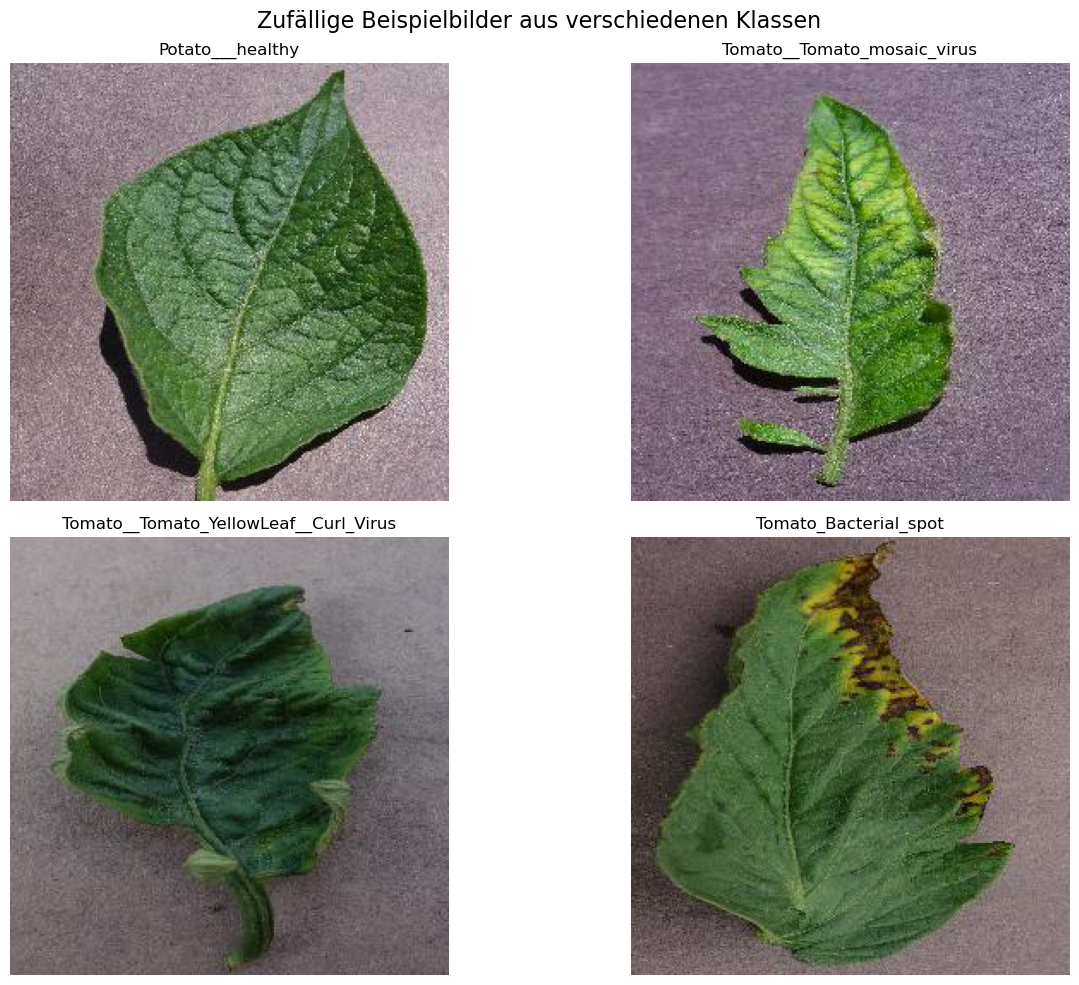

In [3]:
import random
from PIL import Image

# Richtiger PlantVillage-Datenordner
dataset_dir = os.path.join(path, "PlantVillage", "PlantVillage")

print("Datensatzordner:", dataset_dir)

# --- Klassenordner laden ---
folders = [
    f for f in os.listdir(dataset_dir)
    if os.path.isdir(os.path.join(dataset_dir, f))
]

print("Anzahl Klassen:", len(folders))
print("Beispeilklassen:", folders[:10])

# --- Bilder pro Klasse zählen ---
class_counts = {}
total_images = 0 

for cls in folders:
    cls_path = os.path.join(dataset_dir, cls)
    images = [
        f for f in os.listdir(cls_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]
    class_counts[cls] = len(images)
    total_images += len(images)

print("\nBilder pro Klasse:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

print(f"\nGesamtanzahl aller Bilder im Datensatz: {total_images}")

# --- Beispielbilder anzeigen ---
sample_classes = random.sample(folders, 4)

plt.figure(figsize=(14, 10))
for i, cls in enumerate(sample_classes):
    cls_path = os.path.join(dataset_dir, cls)
    images = [
        f for f in os.listdir(cls_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]
    
    if not images:
        continue  # überspringt leere Ordner, falls vorhanden
    
    img_path = os.path.join(cls_path, random.choice(images))
    img = Image.open(img_path)

    plt.subplot(2, 2, i + 1)  # 2x2 Layout
    plt.imshow(img)
    plt.title(cls, fontsize=12)
    plt.axis("off")

plt.suptitle("Zufällige Beispielbilder aus verschiedenen Klassen", fontsize=16)
plt.tight_layout()
plt.show()


### Barplot der Klassenverteilung 

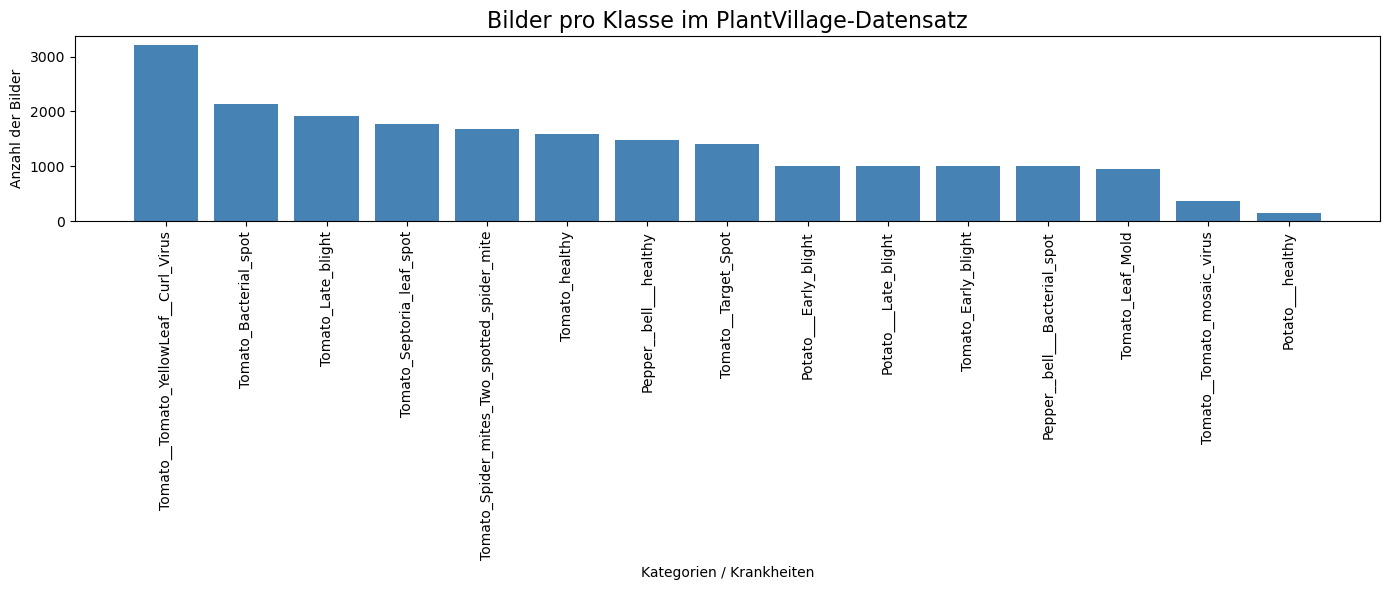

In [4]:
# Dictionary in DataFrame umwandeln
class_df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['count'])
class_df = class_df.sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(14, 6))
plt.bar(class_df.index, class_df['count'], color='steelblue')
plt.xticks(rotation=90)
plt.title("Bilder pro Klasse im PlantVillage-Datensatz", fontsize=16)
plt.xlabel("Kategorien / Krankheiten")
plt.ylabel("Anzahl der Bilder")
plt.tight_layout()
plt.show()


## Erstellung eines DataFrames

In [5]:
image_paths = []
labels = []

# Durchlaufe jede Klasse und sammle Bildpfade
for cls in folders:
    cls_path = os.path.join(dataset_dir, cls)
    
    images = [
        f for f in os.listdir(cls_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]
    
    for img in images:
        image_paths.append(os.path.join(cls_path, img))
        labels.append(cls)

# In DataFrame überführen
df = pd.DataFrame({
    "path": image_paths,
    "label": labels
})

print(len(df))
df.head()


20638


,path,label
0,C:\Users\thien\.cache\kagglehub\datasets\emmar...,Pepper__bell___Bacterial_spot
1,C:\Users\thien\.cache\kagglehub\datasets\emmar...,Pepper__bell___Bacterial_spot
2,C:\Users\thien\.cache\kagglehub\datasets\emmar...,Pepper__bell___Bacterial_spot
3,C:\Users\thien\.cache\kagglehub\datasets\emmar...,Pepper__bell___Bacterial_spot
4,C:\Users\thien\.cache\kagglehub\datasets\emmar...,Pepper__bell___Bacterial_spot


## Train/Val/Test Split

In [6]:
# --- 1. Split: Train + Temp (Val+Test) ---
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,     # 70% Train, 30% Temp
    stratify=df["label"],
    random_state=42
)

# --- 2. Split: Temp -> Validation + Test ---
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,     # Hälfte der 30% -> 15% Test, 15% Val
    stratify=temp_df["label"],
    random_state=42
)

# --- Ausgabe der Größen ---
print("Größe der Datensplits:")
print("Training:", len(train_df))
print("Validation:", len(val_df))
print("Test:", len(test_df))

# --- Prüfung: Anzahl Klassen unverändert? ---
print("\nAnzahl Klassen:")
print("Train:", train_df["label"].nunique())
print("Val:", val_df["label"].nunique())
print("Test:", test_df["label"].nunique())

Größe der Datensplits:
Training: 14446
Validation: 3096
Test: 3096

Anzahl Klassen:
Train: 15
Val: 15
Test: 15


## ImageDataGenerator + Augmentation + Data Pipeline

In [7]:
IMG_SIZE = (118, 118)
BATCH_SIZE = 32

# --- Trainingsgenerator (mit Augmentation) ---
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

# --- Validierungs- & Testgenerator (ohne Augmentation) ---
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

# --- Generatoren erstellen ---
train_flow = train_gen.flow_from_dataframe(
    train_df,
    x_col="path",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_flow = val_gen.flow_from_dataframe(
    val_df,
    x_col="path",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_flow = test_gen.flow_from_dataframe(
    test_df,
    x_col="path",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  # Test-Set nie mischen
)


Found 14446 validated image filenames belonging to 15 classes.
Found 3096 validated image filenames belonging to 15 classes.
Found 3096 validated image filenames belonging to 15 classes.


## erstes Baseline-CNN

In [8]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', padding="same", input_shape=(118, 118, 3)),
    MaxPooling2D(2,2),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(folders), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


c:\Users\thien\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [13]:
# --- Training ---
history = model.fit(
    train_flow, 
    epochs=10, 
    validation_data=val_flow, 
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 140s 308ms/step - accuracy: 0.7417 - loss: 0.7627 - val_accuracy: 0.6518 - val_loss: 1.2593
Epoch 2/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 133s 295ms/step - accuracy: 0.7686 - loss: 0.6935 - val_accuracy: 0.7755 - val_loss: 0.7210
Epoch 3/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 123s 271ms/step - accuracy: 0.7773 - loss: 0.6496 - val_accuracy: 0.7755 - val_loss: 0.6921
Epoch 4/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 123s 271ms/step - accuracy: 0.7936 - loss: 0.6081 - val_accuracy: 0.7775 - val_loss: 0.7414
Epoch 5/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 116s 257ms/step - accuracy: 0.8105 - loss: 0.5719 - val_accuracy: 0.7552 - val_loss: 0.8805


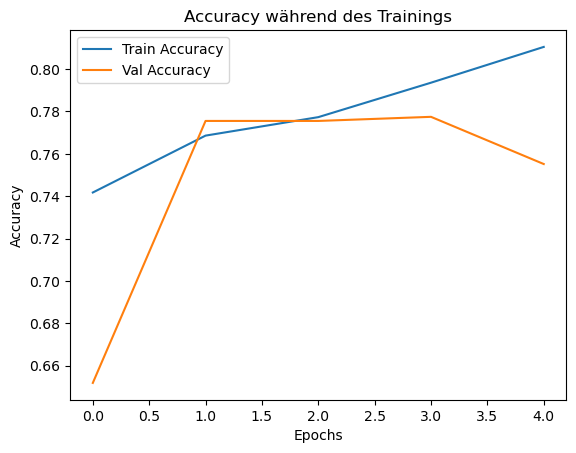

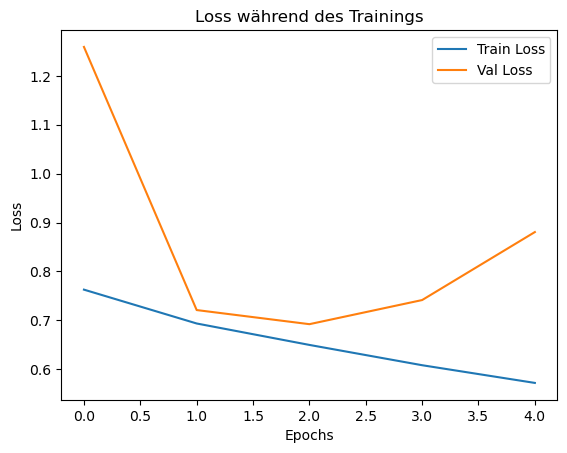

In [14]:
# --- Plots ---
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy während des Trainings')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss während des Trainings')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Modellbewertung auf dem Testdatensatz

In [15]:
test_flow.reset()

# Vorhersagen
y_pred = model.predict(test_flow)
y_pred_classes = np.argmax(y_pred, axis=1)

# Wahre Labels
y_true = test_flow.classes

# Klassennamen
class_names = list(test_flow.class_indices.keys())

print("Anzahl der Testbilder:", len(y_true))

97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step
Anzahl der Testbilder: 3096


In [16]:
print(classification_report(
    y_true, 
    y_pred_classes, 
    target_names=class_names    
))

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.66      0.79      0.72       149
                     Pepper__bell___healthy       0.89      0.87      0.88       221
                      Potato___Early_blight       0.73      0.93      0.82       150
                       Potato___Late_blight       0.73      0.65      0.69       150
                           Potato___healthy       0.55      0.26      0.35        23
                      Tomato_Bacterial_spot       0.94      0.82      0.88       319
                        Tomato_Early_blight       0.61      0.49      0.54       150
                         Tomato_Late_blight       0.87      0.70      0.78       287
                           Tomato_Leaf_Mold       0.92      0.66      0.77       143
                  Tomato_Septoria_leaf_spot       0.80      0.79      0.79       266
Tomato_Spider_mites_Two_spotted_spider_mite       0.73      0.65

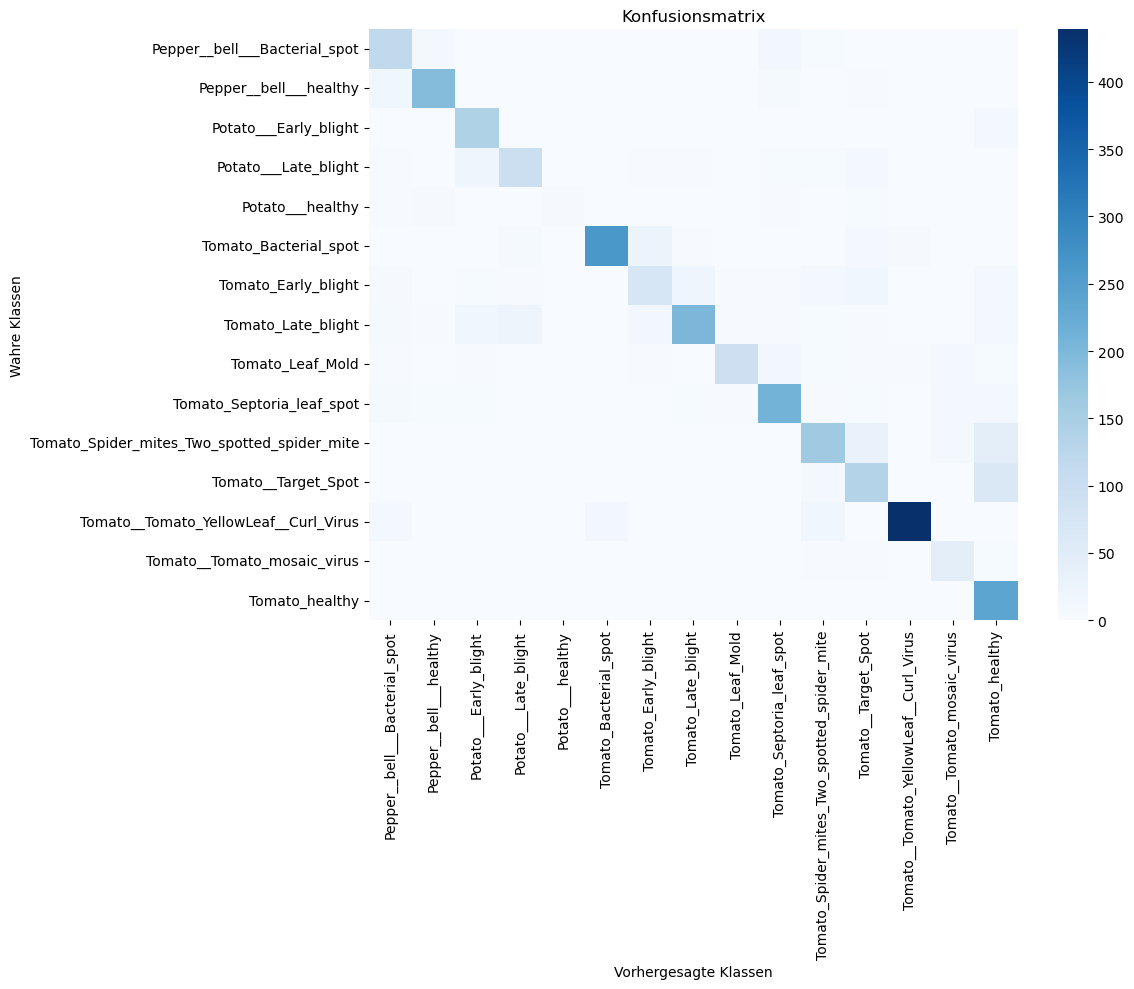

In [17]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Vorhergesagte Klassen")
plt.ylabel("Wahre Klassen")
plt.title("Konfusionsmatrix")
plt.tight_layout()
plt.show()